In [1]:
import torch
import torchvision.datasets as data
import torchvision.transforms as transforms
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [3]:

# 학습 파라미터 설정
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.3


#### 데이터셋 로드
- root: 저장경로
- 학습/테스트 데이터 선택: True 학습데이터
- transform:
- download: 


In [4]:
mnist_train = data.MNIST(root='MNIST_data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

mnist_test = data.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

# shuffle OFF
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)


![대체 텍스트](https://user-images.githubusercontent.com/11758940/83336289-229ec200-a2ed-11ea-9fb8-88a51198e475.png)

In [6]:
linear1 = torch.nn.Linear(784,512,bias=True)
linear2 = torch.nn.Linear(512,512,bias=True)
linear3 = torch.nn.Linear(512,512,bias=True)
linear4 = torch.nn.Linear(512,512,bias=True)
linear5 = torch.nn.Linear(512,10,bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

[메뉴얼] https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_

In [7]:
# Random Init => Xavier Init
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

In [8]:
model = torch.nn.Sequential(linear1,relu,dropout,
                            linear2,relu,dropout,
                            linear3,relu,dropout,
                            linear4,relu,dropout,
                            linear5).to(device)

[메뉴얼] https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [9]:
# 손실함수와 최적화 함수
loss = torch.nn.CrossEntropyLoss().to(device) # softmax 내부적으로 계산
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [10]:

plt_acc = []
plt_los = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)


for epoch in range(training_epochs):
    avg_cost = 0

    model.train()
    for X, Y in train_loader:

        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = loss(hypothesis, Y)
        cost.backward()
        optimizer.step()
        avg_cost += cost / train_total_batch
      

    with torch.no_grad():
        model.eval()  # 주의사항 
        train_accuracy = 0
        train_loss = 0
        for i, (_X, _Y) in enumerate(train_loader):
            _X = _X.view(-1, 28 * 28).to(device)
            _Y = _Y.to(device)

            prediction = model(_X)
            correct_prediction = torch.argmax(prediction, 1) == _Y
            train_loss += loss(prediction, _Y)
            train_accuracy += correct_prediction.float().mean()

        train_acc = train_accuracy.item()/train_total_batch
        train_los = train_loss.item()/train_total_batch
        print('Train Accuracy:', train_acc, 'Train Loss:', train_los )
        


    with torch.no_grad():
        model.eval()  # 주의사항 
        test_accuracy = 0
        test_loss = 0
        for i, (_X, _Y) in enumerate(test_loader):
            _X = _X.view(-1, 28 * 28).to(device)
            _Y = _Y.to(device)

            prediction = model(_X)
            correct_prediction = torch.argmax(prediction, 1) == _Y
            test_loss += loss(prediction, _Y)
            test_accuracy += correct_prediction.float().mean()
        
        test_acc = test_accuracy.item()/test_total_batch
        test_los = test_loss.item()/test_total_batch
        print('Test Accuracy:', test_acc, 'Test Loss:', test_los )


    plt_acc.append([train_acc, test_acc])
    plt_los.append([train_los, test_los])

print('Learning finished')

Train Accuracy: 0.9711496988932292 Train Loss: 0.09670249303181966
Test Accuracy: 0.9669998168945313 Test Loss: 0.11171339988708497
Train Accuracy: 0.9765994262695312 Train Loss: 0.0785393460591634
Test Accuracy: 0.968699951171875 Test Loss: 0.10041757583618165
Train Accuracy: 0.9831154378255208 Train Loss: 0.05579230626424154
Test Accuracy: 0.9755999755859375 Test Loss: 0.08186843872070312
Train Accuracy: 0.9865480550130208 Train Loss: 0.04547392845153809
Test Accuracy: 0.9754999542236328 Test Loss: 0.07759629249572754
Train Accuracy: 0.9889157104492188 Train Loss: 0.0384123961130778
Test Accuracy: 0.9773002624511719 Test Loss: 0.08107943534851074
Train Accuracy: 0.9904982503255209 Train Loss: 0.03111072858174642
Test Accuracy: 0.9791999816894531 Test Loss: 0.07126454830169678
Train Accuracy: 0.9916650390625 Train Loss: 0.02738534609476725
Test Accuracy: 0.9795999908447266 Test Loss: 0.07054955005645752
Train Accuracy: 0.9925319417317708 Train Loss: 0.02371516704559326
Test Accuracy: 

In [11]:
import matplotlib.pyplot as plt

def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='train')
    plt.plot(nn, label='test')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

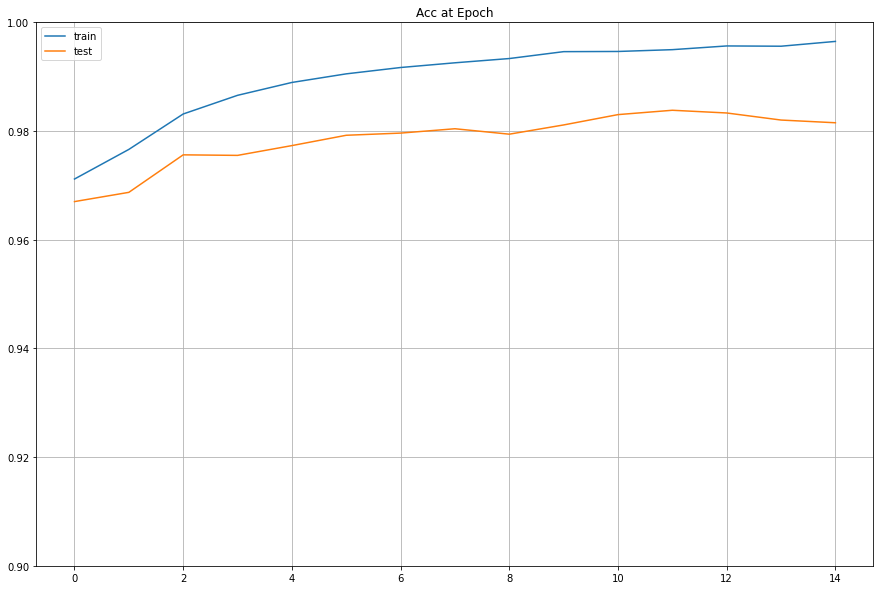

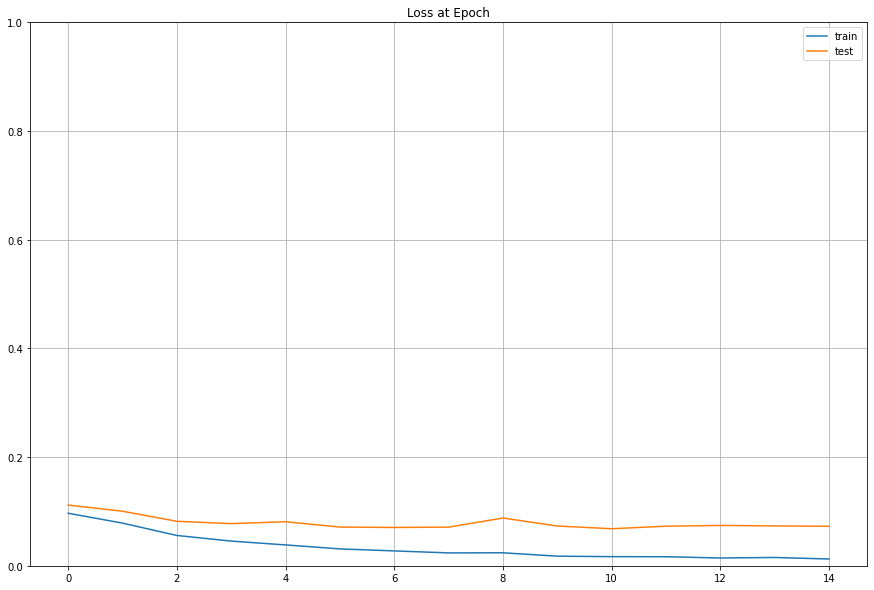

In [12]:

plot_compare(plt_acc , [0.9, 1.0], title='Acc at Epoch')
plot_compare(plt_los , [0.0, 1.0], title='Loss at Epoch')


In [13]:

with torch.no_grad():
  model.eval()  # 주의사항 
  test_accuracy = 0
  for i, (_X, _Y) in enumerate(test_loader):
    _X = _X.view(-1, 28 * 28).to(device)
    _Y = _Y.to(device)

    prediction = model(_X)
    correct_prediction = torch.argmax(prediction, 1) == _Y
    test_accuracy += correct_prediction.float().mean()

  test_acc = test_accuracy.item()/test_total_batch
  print('Test Accuracy:', test_acc)

Test Accuracy: 0.9815003204345704
